Da bi program ispravno radio potrebno je učitati trenirani algoritam model i datoteke za početno postavljanje.

Učitavanje se obavlja klikom na sljedeću ikonu sa strelicom u google colabu

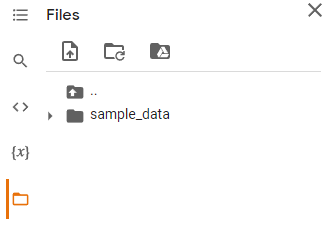

Nakon toga odabirete datoteke za upload, nakon uploada napravite novi folder imena face_detector i u njega ubacite filove depoly.prototx i res10_300x300_ssd_iter_14000.cafemodel

Ako ste sve uploadali kako treba datoteke će izgledati ovako

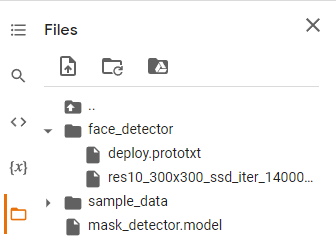

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import argparse
import imutils
import os
from google.colab import files

Da bi korištenje web kamere bilo omogućeno u google colabu potrebno je definirati iduću fukciju koja pretvara JavaScript objekt u OpenCV sliku

In [2]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object koji sadrži sliku
  Returns:
          img: OpenCV BGR slika
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

#funkcija koja pretvara OpenCV kvadrat u base64 byte string koji se dodaje preko prijenosa s web kamere
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (piksela) koji sadrži kvadrat.
  Returns:
        bytes: Base64 image byte string
  """
  # pretvori array u PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # formatira bbox u png
  bbox_PIL.save(iobuf, format='png')
  # formatira return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from google.colab import files

def detect_and_predict_mask(frame, faceNet, maskNet):
	# preuzmi dimenzije slike i napravi blob datoteku od njih
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# predaj blob mreži i izračunaj detekcije
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# inicijaliziraj listu lica, njihove lokacije i listu predikcija
	faces = []
	locs = []
	preds = []

	# for loop detekcija
	for i in range(0, detections.shape[2]):
		# izvlači confidence(koliko je detektor siguran u predikciju)
		# podatak o predikcijama
		confidence = detections[0, 0, i, 2]

		# filtriraj predikcije sa confidence podatkom vecim od praga u default slučaju 50%
		if confidence > args["confidence"]:
			# izračunaj koordinate kvadrata
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# provjeri da li koordinati upadaju u veličinu slike
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# izvlači ROI lica, pretvori iz BGR u RGB kanal,
			# smanju na 224x224, i procesiraj
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# dodaj lice i kvadrad na pripadajuće lokacije
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# napravi predikciju ako je barem jedno lice pronađeno
	if len(faces) > 0:
		# za bržu predikciju obavljamo detekciju na svim licima odjednom
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# vrati tuple lokacije lica i predikcije
	return (locs, preds)

In [10]:
# konstruiraj parser i parsiraj podatke
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args(args=[]))

# učitaj detektor lica s diska
print("[INFO] loading face detector model...")
prototxtPath = '/face_detector/deploy.prototxt'
weightsPath = '/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# učitaj detektor maske za lice
print("[INFO] loading face mask detector model...")
maskNet = load_model('/mask_detector.model')


[INFO] loading face detector model...
[INFO] loading face mask detector model...


Take photo je pomoćna klasa kako bi mogli koristiti kameru u google colab

In [13]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # uzmi podatke sa slika
  data = eval_js('takePhoto({})'.format(quality))
  # pretvori u openCv format
  img = js_to_image(data)
  # grayscale slike
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  (locs, preds) = detect_and_predict_mask(img, faceNet, maskNet)
  # nacrtaj kvadrate oko lica
  for (box, pred) in zip(locs, preds):
		# predikcije i lokacije
	  (startX, startY, endX, endY) = box
	  (mask, withoutMask) = pred

		# odredi label koji ide na kvadrat i tekst koji će se ispisati
	  label = "Mask" if mask > withoutMask else "No Mask"
	  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# dodaj i vjerovatnost predikcije
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
  cv2.putText(img, label, (startX, startY - 10),
	  cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
  cv2.imwrite(filename, img)
  return filename

In [14]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # prikaži sliku
  filename = display(Image(filename))
except Exception as err:
  # izbaci error ako ne postoji kamera
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


Pomoćna klasa za rad sa prijenosom sa kamere

In [12]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# započmi prijenos sa kamere
video_stream()
label_html = 'Capturing...'
# inicijaliziraj prazan kvadrat
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # pretvori u openCV sliku
    img = js_to_image(js_reply["img"])

    # napravi overlay
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale slika
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # dohvati lokacije i predikicje maske
    (locs, preds) = detect_and_predict_mask(img, faceNet, maskNet)
    # dohavti kvadrat za pikazati na ekranu
    for (box, pred) in zip(locs, preds):
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      bbox_array = cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)
      cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)


    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # pretvori array to bbox
    bbox_bytes = bbox_to_bytes(bbox_array)
    # dodaj overlay
    bbox = bbox_bytes